In [73]:
import os
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
import math

from matplotlib.font_manager import FontProperties
font = FontProperties(fname= "c:\Windows\Fonts\MSJH.TTC")


from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


ModuleNotFoundError: No module named 'catboost'

In [2]:
# dataset
training_data_file = "C:/Users/88697/Desktop/永豐AI/training_data.csv"
testing_data_file = "C:/Users/88697/Desktop/永豐AI/public_dataset.csv"
testing_submit = "C:/Users/88697/Desktop/永豐AI/public_submission_template.csv"

# external data
train_file = "C:/Users/88697/Desktop/永豐AI/external_data/火車站點資料.csv"
bus_file = "C:/Users/88697/Desktop/永豐AI/external_data/公車站點資料.csv"
mrt_file = "C:/Users/88697/Desktop/永豐AI/external_data/捷運站點資料.csv"
con_file = "C:/Users/88697/Desktop/永豐AI/external_data/便利商店.csv"
ele_file = "C:/Users/88697/Desktop/永豐AI/external_data/國小基本資料.csv"
jun_file = "C:/Users/88697/Desktop/永豐AI/external_data/國中基本資料.csv"
high_file = "C:/Users/88697/Desktop/永豐AI/external_data/高中基本資料.csv"
uni_file = "C:/Users/88697/Desktop/永豐AI/external_data/大學基本資料.csv"
fin_file = "C:/Users/88697/Desktop/永豐AI/external_data/金融機構基本資料.csv"
hos_file = "C:/Users/88697/Desktop/永豐AI/external_data/醫療機構基本資料.csv"

# Read data
train_df = pd.read_csv(training_data_file, nrows=5000000)
test_df = pd.read_csv(testing_data_file)
test_sb = pd.read_csv(testing_submit)
train_extra = pd.read_csv(train_file)
bus_extra = pd.read_csv(bus_file)
mrt_extra = pd.read_csv(mrt_file)
con_extra = pd.read_csv(con_file)
ele_extra = pd.read_csv(ele_file)
jun_extra = pd.read_csv(jun_file)
high_extra = pd.read_csv(high_file)
fin_extra = pd.read_csv(fin_file)
hos_extra = pd.read_csv(hos_file)
uni_extra = pd.read_csv(uni_file)


In [3]:
# loss function
def mape_loss(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def lonlat_to_97(lon,lat):
    """
    It transforms longitude, latitude to TWD97 system.

    Parameters
    ----------
    lon : float
        longitude in degrees
    lat : float
        latitude in degrees 

    Returns
    -------
    x, y [TWD97]
    """
    
    lat = math.radians(lat)
    lon = math.radians(lon)
    
    a = 6378137.0
    b = 6356752.314245
    long0 = math.radians(121)
    k0 = 0.9999
    dx = 250000

    e = (1-b**2/a**2)**0.5
    e2 = e**2/(1-e**2)
    n = (a-b)/(a+b)
    nu = a/(1-(e**2)*(math.sin(lat)**2))**0.5
    p = lon-long0

    A = a*(1 - n + (5/4.0)*(n**2 - n**3) + (81/64.0)*(n**4  - n**5))
    B = (3*a*n/2.0)*(1 - n + (7/8.0)*(n**2 - n**3) + (55/64.0)*(n**4 - n**5))
    C = (15*a*(n**2)/16.0)*(1 - n + (3/4.0)*(n**2 - n**3))
    D = (35*a*(n**3)/48.0)*(1 - n + (11/16.0)*(n**2 - n**3))
    E = (315*a*(n**4)/51.0)*(1 - n)

    S = A*lat - B*math.sin(2*lat) + C*math.sin(4*lat) - D*math.sin(6*lat) + E*math.sin(8*lat)

    K1 = S*k0
    K2 = k0*nu*math.sin(2*lat)/4.0
    K3 = (k0*nu*math.sin(lat)*(math.cos(lat)**3)/24.0) * (5 - math.tan(lat)**2 + 9*e2*(math.cos(lat)**2) + 4*(e2**2)*(math.cos(lat)**4))

    y_97 = K1 + K2*(p**2) + K3*(p**4)

    K4 = k0*nu*math.cos(lat)
    K5 = (k0*nu*(math.cos(lat)**3)/6.0) * (1 - math.tan(lat)**2 + e2*(math.cos(lat)**2))

    x_97 = K4*p + K5*(p**3) + dx
    return x_97, y_97

In [5]:
def twd97_to_lonlat(x,y):
    """
    Parameters
    ----------
    x : float
        TWD97 coord system. The default is 174458.0.
    y : float
        TWD97 coord system. The default is 2525824.0.
    Returns
    -------
    list
        [longitude, latitude]
    """
    
    a = 6378137
    b = 6356752.314245
    long_0 = 121 * math.pi / 180.0
    k0 = 0.9999
    dx = 250000
    dy = 0
    
    e = math.pow((1-math.pow(b, 2)/math.pow(a,2)), 0.5)
    
    x = x - dx
    y = y - dy
    
    M = y / k0
    
    mu = M / ( a*(1-math.pow(e, 2)/4 - 3*math.pow(e,4)/64 - 5 * math.pow(e, 6)/256))
    e1 = (1.0 - pow((1   - pow(e, 2)), 0.5)) / (1.0 +math.pow((1.0 -math.pow(e,2)), 0.5))
    
    j1 = 3*e1/2-27*math.pow(e1,3)/32
    j2 = 21 * math.pow(e1,2)/16 - 55 * math.pow(e1, 4)/32
    j3 = 151 * math.pow(e1, 3)/96
    j4 = 1097 * math.pow(e1, 4)/512
    
    fp = mu + j1 * math.sin(2*mu) + j2 * math.sin(4* mu) + j3 * math.sin(6*mu) + j4 * math.sin(8* mu)
    
    e2 = math.pow((e*a/b),2)
    c1 = math.pow(e2*math.cos(fp),2)
    t1 = math.pow(math.tan(fp),2)
    r1 = a * (1-math.pow(e,2)) / math.pow( (1-math.pow(e,2)* math.pow(math.sin(fp),2)), (3/2))
    n1 = a / math.pow((1-math.pow(e,2)*math.pow(math.sin(fp),2)),0.5)
    d = x / (n1*k0)
    
    q1 = n1* math.tan(fp) / r1
    q2 = math.pow(d,2)/2
    q3 = ( 5 + 3 * t1 + 10 * c1 - 4 * math.pow(c1,2) - 9 * e2 ) * math.pow(d,4)/24
    q4 = (61 + 90 * t1 + 298 * c1 + 45 * math.pow(t1,2) - 3 * math.pow(c1,2) - 252 * e2) * math.pow(d,6)/720
    lat = fp - q1 * (q2 - q3 + q4)
    
    
    q5 = d
    q6 = (1+2*t1+c1) * math.pow(d,3) / 6
    q7 = (5 - 2 * c1 + 28 * t1 - 3 * math.pow(c1,2) + 8 * e2 + 24 * math.pow(t1,2)) * math.pow(d,5) / 120
    lon = long_0 + (q5 - q6 + q7) / math.cos(fp)
    
    lat = (lat*180) / math.pi
    lon = (lon*180) / math.pi
    return [lon, lat]

In [6]:
def transform_lat(extra_data):
    trans_x = []
    trans_y = []
    for i in range(len(extra_data)):
        x,y = lonlat_to_97(extra_data['lng'][i],extra_data['lat'][i])
        trans_x.append(x)
        trans_y.append(y)
    return trans_x,trans_y

In [7]:
def haversine(lat1,long1,lat2,long2):
    R = 6371  #radius of earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(long2 - long1)
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    return d

In [8]:
def compute_distance(long1,lat1,train_x,train_y):
    long2,lat2 = twd97_to_lonlat(train_x,train_y)
    d = haversine(lat1,long1,lat2,long2)
    return d

In [9]:
#計算最近的火車站與火車站之間距離
def nearest_train_station(extra,train):
    nearest = []
    distance = []
    for i in range(len(train)):
        nearest_station = None
        min_distance = float("inf")

        for j in range(len(extra)):
            # compute distance
            d = compute_distance(extra['lng'][j],extra['lat'][j],train['橫坐標'][i],train['縱坐標'][i])
            if d < min_distance:
                min_distance = d
                nearest_station = extra['車站級別'][j]
        nearest.append(nearest_station)
        distance.append(min_distance)
    train['最近火車站'] = nearest
    train['最近火車站距離'] = distance
    return

In [10]:
#計算方圓一定距離內出現站點數量
def station_count(extra,train,target_distance,name):
    count = []
    for i in range(len(train)):
        station_count = 0
        for j in range(len(extra)):
            d = compute_distance(extra['lng'][j],extra['lat'][j],train['橫坐標'][i],train['縱坐標'][i])
            if d <= target_distance:
                station_count += 1
        count.append(station_count)
    train[name] = count
    return

In [11]:
nearest_train_station(train_extra,train_df)
nearest_train_station(train_extra,test_df)

In [12]:
#方圓800公尺內捷運站數量
station_count(mrt_extra,train_df,0.8,'捷運站數量')
station_count(mrt_extra,test_df,0.8,'捷運站數量')

In [13]:
#方圓300公尺內便利商店數量
station_count(con_extra,train_df,0.3,'便利商店數量')
station_count(con_extra,test_df,0.3,'便利商店數量')

In [14]:
#方圓300公尺內國小數量
station_count(ele_extra,train_df,0.3,'國小數量')
station_count(ele_extra,test_df,0.3,'國小數量')

In [15]:
#方圓800公尺內國中數量
station_count(jun_extra,train_df,0.8,'國中數量')
station_count(jun_extra,test_df,0.8,'國中數量')

In [16]:
#方圓1000公尺內高中數量
station_count(high_extra,train_df,1.0,'高中數量')
station_count(high_extra,test_df,1.0,'高中數量')

In [17]:
#方圓1000公尺內大學數量
station_count(uni_extra,train_df,1.0,'大學數量')
station_count(uni_extra,test_df,1.0,'大學數量')

In [18]:
#方圓1000公尺內金融機構數量
station_count(fin_extra,train_df,1.0,'金融機構數量')
station_count(fin_extra,test_df,1.0,'金融機構數量')

In [19]:
#方圓300公尺內醫院數量
station_count(hos_extra,train_df,0.3,'醫院數量')
station_count(hos_extra,test_df,0.3,'醫院數量')

In [20]:
train_df.describe()

,土地面積,移轉層次,總樓層數,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,主建物面積,...,最近火車站,最近火車站距離,捷運站數量,便利商店數量,國小數量,國中數量,高中數量,大學數量,金融機構數量,醫院數量
count,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,1.175100e+04,11751.000000,...,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000
mean,0.018416,7.433665,12.602672,21.319058,0.030517,0.021030,0.638669,268260.431878,2.719114e+06,0.026623,...,2.297592,3.946904,0.809123,5.054719,0.457833,1.168496,1.046039,1.161603,17.326355,9.945281
std,1.072279,5.089029,6.840007,14.425560,1.083602,1.030720,0.678157,50065.477460,9.271248e+04,1.077374,...,1.474848,11.474784,1.205408,3.474868,1.134408,1.136339,1.168454,2.637151,19.362722,11.089960
min,-1.619755,2.000000,2.000000,0.000000,-1.909259,-0.819326,0.000000,-23391.000000,2.493809e+06,-2.070340,...,0.000000,0.014161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.646264,4.000000,7.000000,8.083333,-0.619995,-0.819326,0.000000,237588.500000,2.708082e+06,-0.612460,...,1.000000,1.390980,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000
50%,-0.149839,6.000000,12.000000,21.750000,-0.191390,-0.334257,1.000000,294675.000000,2.766329e+06,-0.148660,...,1.000000,2.510331,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,12.000000,7.000000
75%,0.410167,10.000000,15.000000,31.250000,0.339483,0.677589,1.000000,302130.000000,2.772017e+06,0.395765,...,4.000000,4.386275,1.000000,7.000000,1.000000,2.000000,2.000000,0.000000,22.000000,15.000000
max,19.475175,46.000000,68.000000,60.083333,13.026437,14.007695,3.000000,334128.000000,2.790801e+06,12.099402,...,5.000000,228.461947,7.000000,28.000000,10.000000,8.000000,7.000000,17.000000,133.000000,126.000000


In [21]:
# 使用分區 {住:1, 商:2, 農:3, 工:4, 其他:0}
mapping = {'住':1, '商':2, '農':3, '工':4}
train_df['使用分區'] = train_df['使用分區'].map(mapping).fillna(0).astype(int)
test_df['使用分區'] = test_df['使用分區'].map(mapping).fillna(0).astype(int)

# 主要建材 {鋼筋混凝土造:1, 鋼骨造:2, 加強磚造:3, 其他:0}
mapping = {'鋼筋混凝土造':1, '鋼骨造':2, '加強磚造':3}
train_df['主要建材'] = train_df['主要建材'].map(mapping).fillna(0).astype(int)
test_df['主要建材'] = test_df['主要建材'].map(mapping).fillna(0).astype(int)

# 建物型態 {住宅大樓:1, 公寓 3:華廈 4:透天厝 0:其他}
mapping = {'住宅大樓(11層含以上有電梯)':1, '公寓(5樓含以下無電梯)':2, '華廈(10層含以下有電梯)':3, '透天厝':4}
train_df['建物型態'] = train_df['建物型態'].map(mapping).fillna(0).astype(int)
test_df['建物型態'] = test_df['建物型態'].map(mapping).fillna(0).astype(int)

# 主要用途 {住家用:1, 集合住宅:2, 商業用:3, 一般事務所:4, 國民住宅:5, 住商用:6, 工業用:7, 辦公室:8, 住工用:9, 店鋪:10, 廠房:11, 其他:0}
mapping = {'住家用':1, '集合住宅':2, '商業用':3, '一般事務所':4, '國民住宅':5, '住商用':6, '工業用':7, '辦公室':8, '住工用':9, '店鋪':10, '廠房':11, '其他':0}
train_df['主要用途'] = train_df['主要用途'].map(mapping).fillna(0).astype(int)
test_df['主要用途'] = test_df['主要用途'].map(mapping).fillna(0).astype(int)

In [22]:
def map_city_area(row,city,mapping):
    if row['縣市'] == city:
        return mapping.get(row['鄉鎮市區'], 0)
    else:
        return -1

# 六都區域mapping

# 台北市 （其他: 0, 別的縣市: -1）
mapping = {'大安區': 1, '中山區': 2, '內湖區': 3, '信義區': 4, '士林區': 5, '文山區': 6, '松山區': 7,
           '北投區': 8, '中正區': 9, '萬華區': 10, '大同區': 11, '南港區': 12}
train_df['台北市區'] = train_df.apply(map_city_area, args=('台北市', mapping), axis=1)
test_df['台北市區'] = test_df.apply(map_city_area, args=('台北市', mapping), axis=1)

# 新北市
mapping = {'板橋區': 1, '新莊區': 2, '中和區': 3, '三重區': 4, '汐止區': 5, '新店區': 6, '土城區': 7,
           '林口區': 8, '永和區': 9, '淡水區': 10, '蘆洲區': 11, '五股區': 12, '樹林區': 13, '三峽區': 14, '鶯歌區': 15,
           '泰山區':16, '深坑區':17, '八里區':18}
train_df['新北市區'] = train_df.apply(map_city_area, args=('新北市', mapping), axis=1)
test_df['新北市區'] = test_df.apply(map_city_area, args=('新北市', mapping), axis=1)

# 桃園市
mapping = {'桃園區': 1, '中壢區': 2, '蘆竹區': 3, '八德區': 4, '龜山區': 5, '平鎮區': 6, '楊梅區': 7,
           '大園區': 8, '大溪區': 9, '龍潭區': 10, '觀音區': 11}   
train_df['桃園市區'] = train_df.apply(map_city_area, args=('桃園市', mapping), axis=1)
test_df['桃園市區'] = test_df.apply(map_city_area, args=('桃園市', mapping), axis=1)

# 台中市 
mapping = {'西屯區': 1, '北屯區': 2, '南屯區': 3, '南區': 4, '西區': 5, '北區': 6, '太平區': 7,
           '大里區': 8, '潭子區': 9, '烏日區': 10, '東區': 11, '豐原區': 12, '神岡區': 13, '大雅區': 14, '中區': 15}   
train_df['台中市區'] = train_df.apply(map_city_area, args=('台中市', mapping), axis=1)
test_df['台中市區'] = test_df.apply(map_city_area, args=('台中市', mapping), axis=1)


# 台南市
mapping = {'永康區': 1, '安平區': 2, '北區': 3, '東區': 4, '中西區': 5, '南區': 6, '安南區': 7,
           '仁德區': 8, '善化區': 9, '新市區': 10, '新營區': 11}   
train_df['台南市區'] = train_df.apply(map_city_area, args=('台南市', mapping), axis=1)
test_df['台南市區'] = test_df.apply(map_city_area, args=('台南市', mapping), axis=1)

# 高雄市
mapping = {'鼓山區': 1, '三民區': 2, '左營區': 3, '楠梓區': 4, '鳳山區': 5, '零雅區': 6, '前鎮區': 7,
           '前金區': 8, '新興區': 9, '仁武區': 10, '小港區': 11, '橋頭區':12, '鹽埕區':13, '岡山區':14, '鳥松區':15}   
train_df['高雄市區'] = train_df.apply(map_city_area, args=('高雄市', mapping), axis=1)
test_df['高雄市區'] = test_df.apply(map_city_area, args=('高雄市', mapping), axis=1)


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11751 entries, 0 to 11750
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       11751 non-null  object 
 1   縣市       11751 non-null  object 
 2   鄉鎮市區     11751 non-null  object 
 3   路名       11751 non-null  object 
 4   土地面積     11751 non-null  float64
 5   使用分區     11751 non-null  int32  
 6   移轉層次     11751 non-null  int64  
 7   總樓層數     11751 non-null  int64  
 8   主要用途     11751 non-null  int32  
 9   主要建材     11751 non-null  int32  
 10  建物型態     11751 non-null  int32  
 11  屋齡       11751 non-null  float64
 12  建物面積     11751 non-null  float64
 13  車位面積     11751 non-null  float64
 14  車位個數     11751 non-null  float64
 15  橫坐標      11751 non-null  int64  
 16  縱坐標      11751 non-null  int64  
 17  備註       92 non-null     object 
 18  主建物面積    11751 non-null  float64
 19  陽台面積     11751 non-null  float64
 20  附屬建物面積   11751 non-null  float64
 21  單價       117

In [24]:
# New features
train_df['建物佔地比'] = (train_df['建物面積']/train_df['土地面積']).round(5)
train_df['樓高比']=(train_df['移轉層次']/train_df['總樓層數'])

test_df['建物佔地比'] = (test_df['建物面積']/test_df['土地面積']).round(5)
test_df['樓高比']=(test_df['移轉層次']/test_df['總樓層數'])

In [25]:
# 取到小數點後2位
train_df['屋齡'] = train_df['屋齡'].round(2).astype('float32') 

# 取到小數點後5位
train_df['土地面積'] = train_df['土地面積'].round(5).astype('float32') 
train_df['建物面積'] = train_df['建物面積'].round(5).astype('float32') 
train_df['車位面積'] = train_df['車位面積'].round(5).astype('float32') 
train_df['主建物面積'] = train_df['主建物面積'].round(5).astype('float32') 
train_df['陽台面積'] = train_df['陽台面積'].round(5).astype('float32') 
train_df['附屬建物面積'] = train_df['附屬建物面積'].round(5).astype('float32') 


In [26]:
# 縣市 mapping
mapping = {'基隆市':1, '台北市':2, '新北市':3, '桃園市':4, '新竹市':5, '新竹縣':6, '苗栗縣':7,
           '台中市':8, '彰化縣':9, '南投縣':10, '雲林縣':11, '嘉義市':12, '嘉義縣':13, '台南市':14,
           '高雄市':15, '屏東縣':16, '台東縣':17, '花蓮縣':18, '宜蘭縣':19, '澎湖縣':20, '金門縣': 21, '連江縣':22}
train_df['縣市'] = train_df['縣市'].map(mapping).fillna(0).astype(int)
test_df['縣市'] = test_df['縣市'].map(mapping).fillna(0).astype(int)


In [27]:
# dropoff
train_df.drop(columns=['ID'],inplace=True)
train_df.drop(columns=['鄉鎮市區'],inplace=True)
train_df.drop(columns=['路名'],inplace=True)
train_df.drop(columns=['備註'],inplace=True)

test_df.drop(columns=['ID'],inplace=True)
test_df.drop(columns=['鄉鎮市區'],inplace=True)
test_df.drop(columns=['路名'],inplace=True)
test_df.drop(columns=['備註'],inplace=True)

c:\Users\88697\anaconda3\envs\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from current font.
  fig.canvas.draw()
c:\Users\88697\anaconda3\envs\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  fig.canvas.draw()
c:\Users\88697\anaconda3\envs\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 22303 (\N{CJK UNIFIED IDEOGRAPH-571F}) missing from current font.
  fig.canvas.draw()
c:\Users\88697\anaconda3\envs\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.canvas.draw()
c:\Users\88697\anaconda3\envs\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.draw()
c:\Users\88697\anaconda3\envs\python\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 

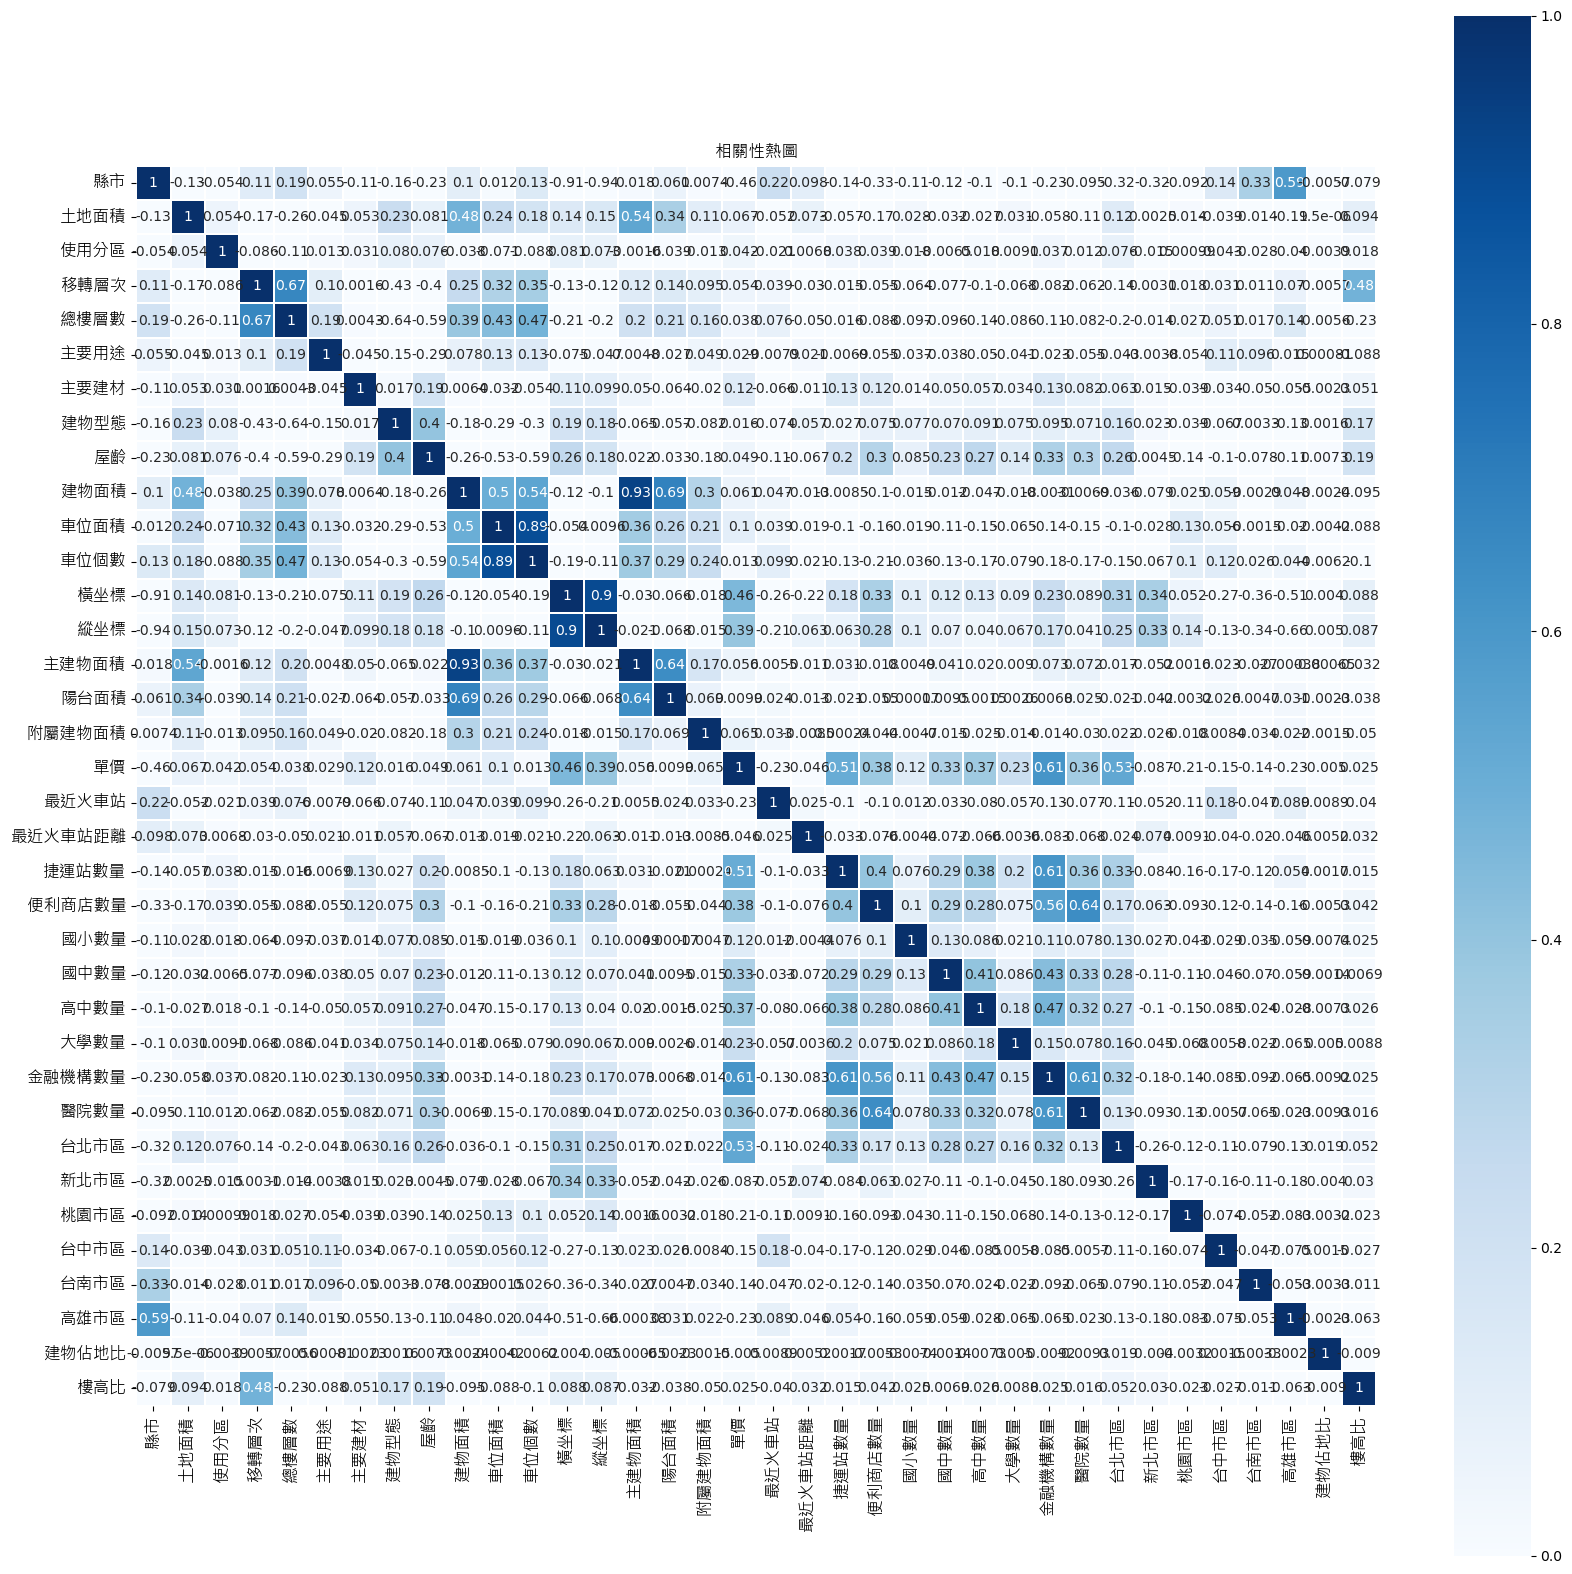

In [28]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(train_df.corr('pearson'), linewidths=0.1, vmax=1.0, vmin=0, 
                     square=True, cmap="Blues", linecolor='white', annot=True)

heatmap.set_title('相關性熱圖', fontproperties=font, fontsize=12, fontweight='bold')
plt.xticks(fontproperties=font, fontsize=12, rotation=90)  
plt.yticks(fontproperties=font, fontsize=12, rotation=0)  

plt.show()

In [115]:
X = train_df.iloc[:,train_df.columns != '單價']
Y = train_df['單價']
X.shape

(11751, 35)

In [116]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

In [117]:
# XGBoost
params = {
    'max_depth': 10,
    'n_estimators':5000,
    'gamma' :0.003,
    'eta':.025, 
    'subsample': 0.9,
    'colsample_bytree': 0.7, 
    'objective':'reg:linear',
    'eval_metric':'mape',
    'silent': 0,
    'verbosity' : 0,
    'random_state' : 42,
}

def XGBmodel(X_train,X_valid,y_train,y_valid,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_valid = xgb.DMatrix(X_valid,label=y_valid)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=10000, 
                    early_stopping_rounds=500,evals=[(matrix_valid,'valid')])
    return model

xgbmodel = XGBmodel(X_train,X_valid,y_train,y_valid,params)

[0]	valid-mape:0.67560


[1]	valid-mape:0.65844
[2]	valid-mape:0.64162
[3]	valid-mape:0.62514
[4]	valid-mape:0.60917
[5]	valid-mape:0.59362
[6]	valid-mape:0.57837
[7]	valid-mape:0.56351
[8]	valid-mape:0.54919
[9]	valid-mape:0.53508
[10]	valid-mape:0.52133
[11]	valid-mape:0.50798
[12]	valid-mape:0.49508
[13]	valid-mape:0.48241
[14]	valid-mape:0.46998
[15]	valid-mape:0.45795
[16]	valid-mape:0.44614
[17]	valid-mape:0.43469
[18]	valid-mape:0.42356
[19]	valid-mape:0.41278
[20]	valid-mape:0.40228
[21]	valid-mape:0.39210
[22]	valid-mape:0.38211
[23]	valid-mape:0.37228
[24]	valid-mape:0.36273
[25]	valid-mape:0.35343
[26]	valid-mape:0.34443
[27]	valid-mape:0.33567
[28]	valid-mape:0.32711
[29]	valid-mape:0.31884
[30]	valid-mape:0.31081
[31]	valid-mape:0.30303
[32]	valid-mape:0.29542
[33]	valid-mape:0.28804
[34]	valid-mape:0.28087
[35]	valid-mape:0.27387
[36]	valid-mape:0.26720
[37]	valid-mape:0.26056
[38]	valid-mape:0.25420
[39]	valid-mape:0.24804
[40]	valid-mape:0.24193
[41]	valid-mape:0.23604
[42]	valid-mape:0.23035
[

In [118]:
# Testing data
X_test = test_df
w1 = 1.0
w2 = 0.0

test_pred_xgb = xgbmodel.predict(xgb.DMatrix(X_test), ntree_limit = xgbmodel.best_ntree_limit).tolist()
test_pred = np.asarray(w1) * test_pred_xgb

submission = pd.DataFrame()
submission['ID'] = test_sb['ID']
submission['predicted_price'] = test_pred
submission.to_csv('C:/Users/88697/Desktop/永豐AI/submission/submission.csv', index=False)

c:\Users\88697\anaconda3\envs\python\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [120]:
valid_pred_xgb = xgbmodel.predict(xgb.DMatrix(X_valid), ntree_limit = xgbmodel.best_ntree_limit).tolist()
valid_pred = np.asarray(w1) * valid_pred_xgb
print("MAPE:", mape_loss(y_valid, valid_pred))

MAPE: 8.961489460480703
